In [2]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [5]:
DATA_STORE = '/Users/Massimiliano/assets.h5'

In [6]:
START = 2000
END = 2018

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['us_equities/stocks'].loc[:, ['Market Cap', 'IPO Year', 'Sector']]

In [8]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


In [9]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4314 entries, AACG to ZYXI
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Market Cap  4302 non-null   float64
 1   IPO Year    2622 non-null   float64
 2   Sector      4184 non-null   object 
dtypes: float64(2), object(1)
memory usage: 134.8+ KB


In [10]:
#Remove stocks duplicates and align index names for later joining.
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

#Get tickers with both price information and metadata
shared = prices.columns.intersection(stocks.index)
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 843 entries, AAL to ZUMZ
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Market Cap  843 non-null    float64
 1   IPO Year    447 non-null    float64
 2   Sector      836 non-null    object 
dtypes: float64(2), object(1)
memory usage: 26.3+ KB


In [11]:
#resamplemonthlyreturns
monthly_prices = prices.resample('M').last()

In [12]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: M
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 5.3 MB


In [13]:
#To capture time series dynamics that reflect, for example, momentum patterns, 
#we compute historical returns using the method .pct_change(n_periods), 
#that is, returns over various monthly periods as identified by lags.

#We then convert the wide result back to long format with the .stack() method, 
#use .pipe() to apply the .clip() method to the resulting DataFrame, and 
#Finally, we normalize returns using the geometric average. 
#winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.
#After using .swaplevel() to change the order of the MultiIndex levels, 
#we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [14]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 521806 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   521806 non-null  float64
 1   return_2m   521806 non-null  float64
 2   return_3m   521806 non-null  float64
 3   return_6m   521806 non-null  float64
 4   return_9m   521806 non-null  float64
 5   return_12m  521806 non-null  float64
dtypes: float64(6)
memory usage: 26.0+ MB


In [15]:
#Drop stocks with less than 10 yrs of returns

In [16]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   465935 non-null  float64
 1   return_2m   465935 non-null  float64
 2   return_3m   465935 non-null  float64
 3   return_6m   465935 non-null  float64
 4   return_9m   465935 non-null  float64
 5   return_12m  465935 non-null  float64
dtypes: float64(6)
memory usage: 23.3+ MB


In [17]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,465935.000000,465935.000000,465935.000000,465935.000000,465935.000000,465935.000000
mean,0.011694,0.008454,0.007306,0.006036,0.005542,0.005285
std,0.117872,0.084059,0.069195,0.050674,0.041919,0.036635
min,-0.343442,-0.269341,-0.229978,-0.175426,-0.145071,-0.125787
25%,-0.046679,-0.031096,-0.024413,-0.015632,-0.012035,-0.009962
50%,0.006369,0.007476,0.007810,0.008024,0.007924,0.007852
75%,0.065314,0.048890,0.041722,0.031742,0.027062,0.024439
max,0.449446,0.294075,0.230064,0.159207,0.128147,0.108809


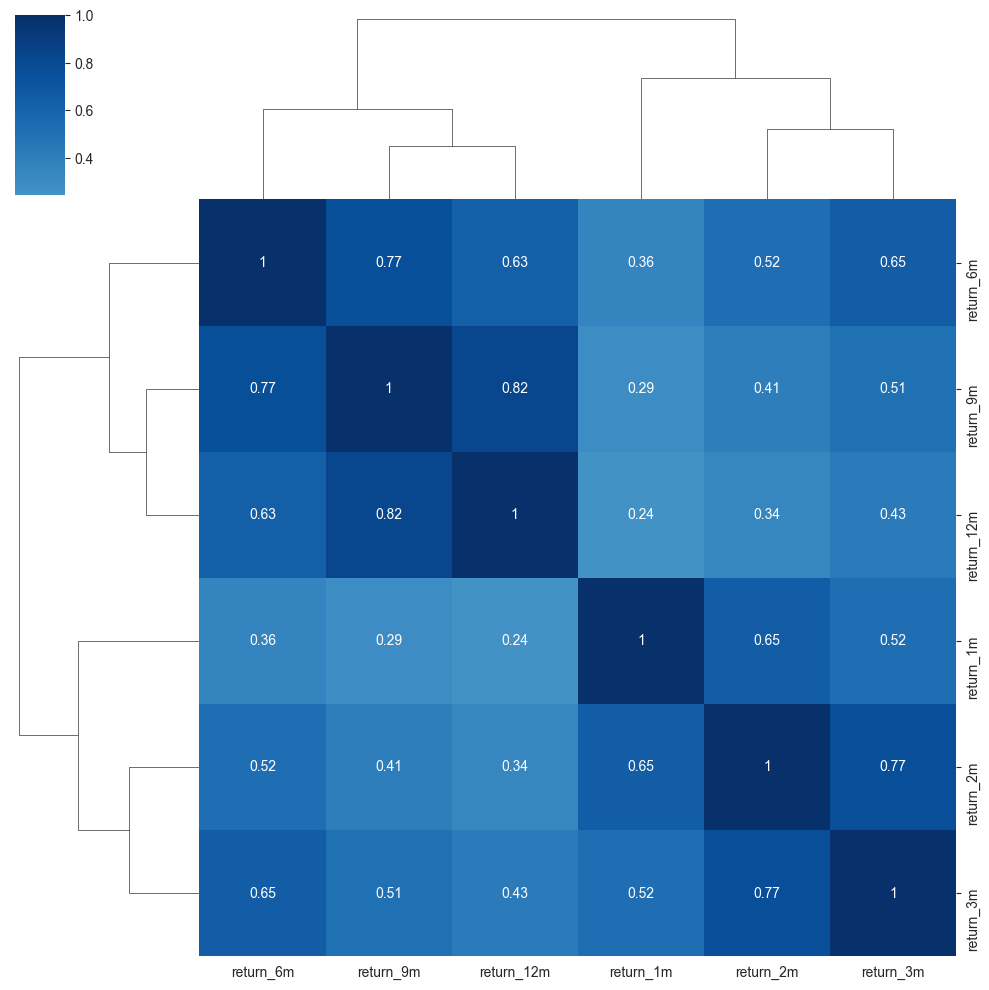

In [18]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

In [19]:
#n of tickers left
data.index.get_level_values('ticker').nunique()

2385

In [20]:
#the five Fama—French factors, namely market risk, size, value, operating profitability,
# and investment have been shown empirically to explain asset returns and are commonly used 
# to assess the risk/return profile of portfolios. Hence, it is natural to include past 
# factor exposures as financial features in models that aim to predict future returns.We can access 
# the historical factor returns using the pandas-datareader and estimate historical exposures 
# using the RollingOLS rolling linear regression functionality in the statsmodels library as follows:
# Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to 
# the 5 factors market risk, size, value, operating profitability and investment.

In [21]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 283 entries, 2000-01-31 to 2023-07-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  283 non-null    float64
 1   SMB     283 non-null    float64
 2   HML     283 non-null    float64
 3   RMW     283 non-null    float64
 4   CMA     283 non-null    float64
dtypes: float64(5)
memory usage: 13.3 KB


In [22]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     465935 non-null  float64
 1   SMB        465935 non-null  float64
 2   HML        465935 non-null  float64
 3   RMW        465935 non-null  float64
 4   CMA        465935 non-null  float64
 5   return_1m  465935 non-null  float64
dtypes: float64(6)
memory usage: 23.3+ MB
